In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Change directory
%cd /content/drive/My Drive/Colab Notebooks/healthcare analytics

/content/drive/My Drive/Colab Notebooks/healthcare analytics


In [3]:
!ls

AfterPCA1.csv  FinalRaw.csv		   PatientPortalUsage.ipynb
AfterPCA.csv   hints5_cycle2_public.csv    TimeSeries.ipynb
Dataset.csv    PatientPortalAnalysis.pptx


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split


In [5]:
df = pd.read_csv('Dataset.csv',parse_dates=True)
features = len(df.columns)
print(features)

19


In [6]:
print(df.shape[0])

241


In [7]:
print(df.head)

<bound method NDFrame.head of      SurgDate  DOW  T - 28  T - 21  T - 14  ...  T - 4  T - 3  T - 2  T - 1  Actual
0    10/10/11  Mon      38      45      60  ...     94     98    100    104     106
1    10/11/11  Tue      35      47      65  ...     99     99     99    114     121
2    10/12/11  Wed      26      43      54  ...    102    102    106    114     126
3    10/13/11  Thu      28      48      65  ...     94     97     98    103     114
4    10/14/11  Fri      31      40      50  ...     78     83     87     94     106
..        ...  ...     ...     ...     ...  ...    ...    ...    ...    ...     ...
236   9/10/12  Mon      33      49      68  ...    101    103    109    110     118
237   9/11/12  Tue      31      56      68  ...     97     98     98     99     108
238   9/12/12  Wed      39      49      69  ...     99    100    104    115     121
239   9/13/12  Thu      34      51      68  ...     99     97    101    106     114
240   9/14/12  Fri      27      41      63  ..

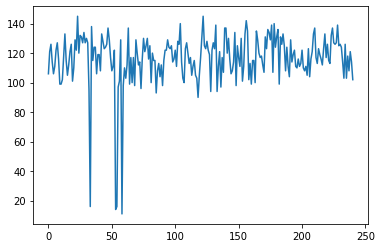

In [8]:
fig,ax=plt.subplots()
df['Actual'].plot(ax=ax)
plt.show()

# Check for Seasonality - patterns that repeat over a time

3 conditions for Stationary:
1. Trend is stationary
2. Variance is constant
3.Auto-correlation is constant

In [9]:
#test for non-stationarity
#Null Hypothesis is time series is non stationary
#use Fuller test

from statsmodels.tsa.stattools import adfuller
results = adfuller(df['Actual'])
print(results)

(-5.152404073250107, 1.0987951103079959e-05, 5, 235, {'1%': -3.4584868856997004, '5%': -2.873918902362675, '10%': -2.573367247623359}, 1923.9318316966262)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


0th element is test statistic - more negative it is - more likely the time series is stationary


Next element is p-value (if p-value is small (< 0.05) then reject the null hypothesis) 

# Autocorrelation Plots

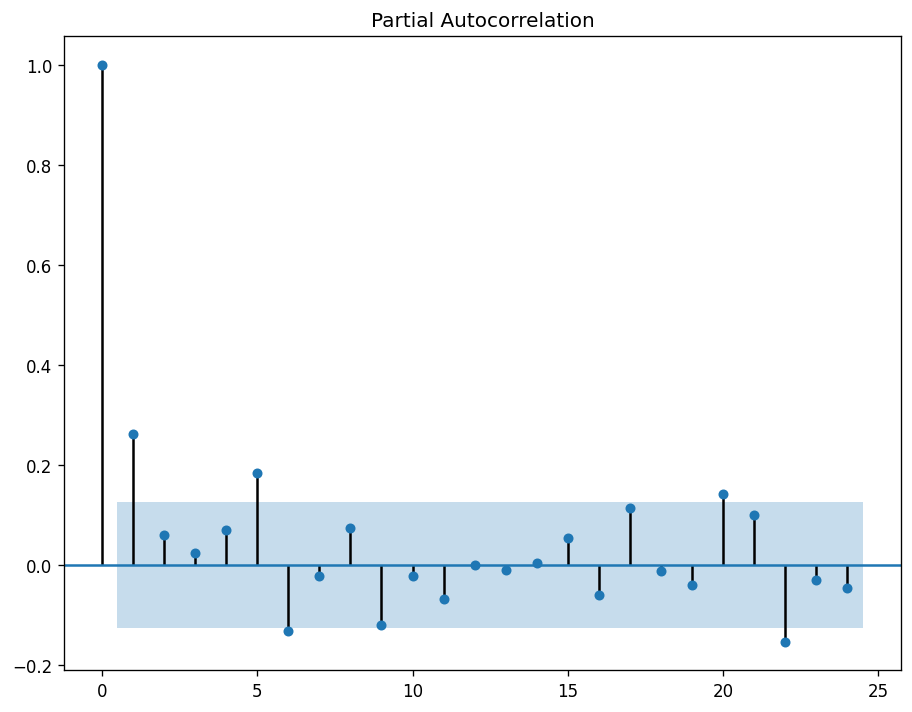

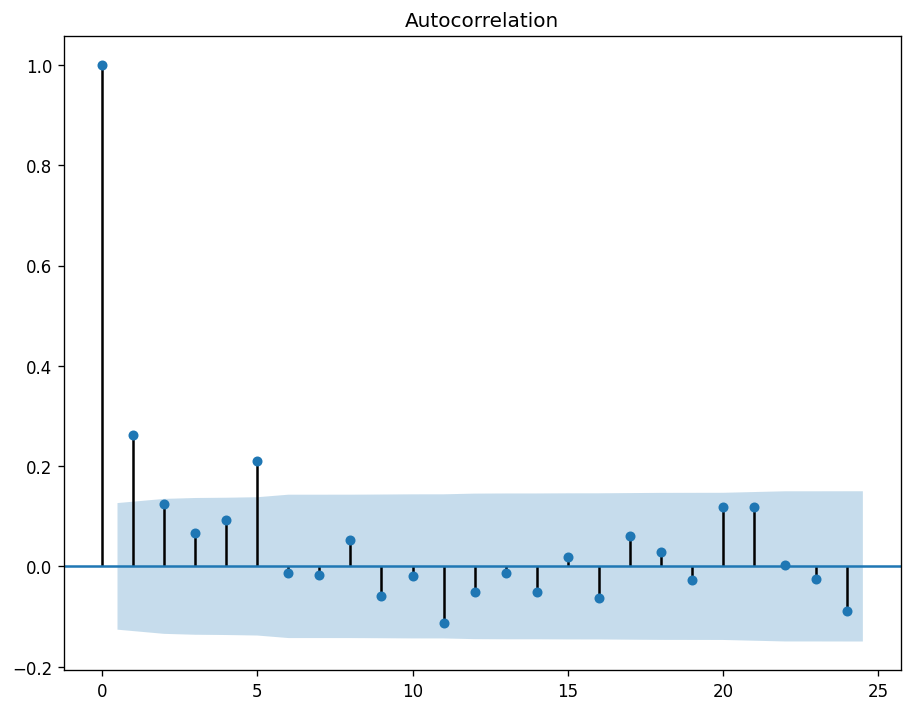

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import matplotlib.pyplot as plt
# plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# # Original Series
# fig, axes = plt.subplots(3, 2, sharex=True)
# axes[0, 0].plot(df.Actual); axes[0, 0].set_title('Original Series')
# plot_acf(df.Actual, ax=axes[0, 1])

# # 1st Differencing
# axes[1, 0].plot(df.Actual.diff()); axes[1, 0].set_title('1st Order Differencing')
# plot_acf(df.Actual.diff().dropna(), ax=axes[1, 1])

# # 2nd Differencing
# axes[2, 0].plot(df.Actual.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
# plot_acf(df.Actual.diff().diff().dropna(), ax=axes[2, 1])

# plt.show()

plot_pacf(df['Actual'])
plt.show()
plot_acf(df['Actual'])
plt.show()

The straight line indicates - stationary model

**An autoregressive model** - we regress the values of time series,against previous values in the same time series

y = (a1* y') + e
where y and e are at time t and y' is at t-1

here e = eplison(shock term) is white noise and is random and unrelated to other shocks in the series
a1 = auto regressive coefficient at lag1

Order of AR model - number of auto regressive coefficients
Generally AR(p) - p auto regressive coefficients and p lags





In a **Moving Average** model - we regress the values of time series,against the previous shock values of the same time series

y = (m1*e')+ e where y is value at time t and is equal to m1 times the shock of previous step plus a shock term at current step - order of the model means how many lags we use - (q) in case of MA models

ARMA is modeled on previous terms and previous shock terms
 https://www.statisticshowto.com/arma-model/



1.   ARMA(p,q) - tells us about the order of AR & MA part
2.   Find the p and q terms
3.   Fit the ARMA model

Theory - https://www.baeldung.com/cs/acf-pacf-plots-arma-modeling



Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. 
So, PACF sort of conveys the pure correlation between a lag and the series. 
This way, we will know if that lag is needed in the AR term or not.

q-3 and p-7

#ARMA Model

In Python, the pmdarima package provides auto_arima() function which can be used to automate the process of ARIMA Forecasting in Python.

auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

We need to install the pmdarima package first

In [19]:
# !pip install pmdarima

In [61]:
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm

model = pm.auto_arima(df.Actual, start_p=1, start_q=1,
                      max_p=7, max_q=5, # maximum p and q
                      m=5,              # frequency of series
                      d=None,          
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=None, start_Q=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# m=1, 5, 0 - all cases best model is 1,0,0
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[5] intercept   : AIC=2056.570, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=2070.058, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=2045.315, Time=1.36 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=2047.952, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=2984.187, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[5] intercept   : AIC=2055.042, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[5] intercept   : AIC=2047.233, Time=1.71 sec
 ARIMA(1,0,0)(1,0,1)[5] intercept   : AIC=2047.296, Time=0.77 sec
 ARIMA(1,0,0)(0,0,1)[5] intercept   : AIC=2045.243, Time=0.30 sec
 ARIMA(1,0,0)(0,0,2)[5] intercept   : AIC=2047.183, Time=0.37 sec
 ARIMA(1,0,0)(1,0,2)[5] intercept   : AIC=2049.183, Time=1.38 sec
 ARIMA(0,0,0)(0,0,1)[5] intercept   : AIC=2060.286, Time=0.13 sec
 ARIMA(2,0,0)(0,0,1)[5] intercept   : AIC=2046.383, Time=0.25 sec
 ARIMA(1,0,1)(0,0,1)[5] intercept   : AIC=2046.797, Time=0.31 sec
 ARIMA(2,0,1)(0,0,1)[5] intercept

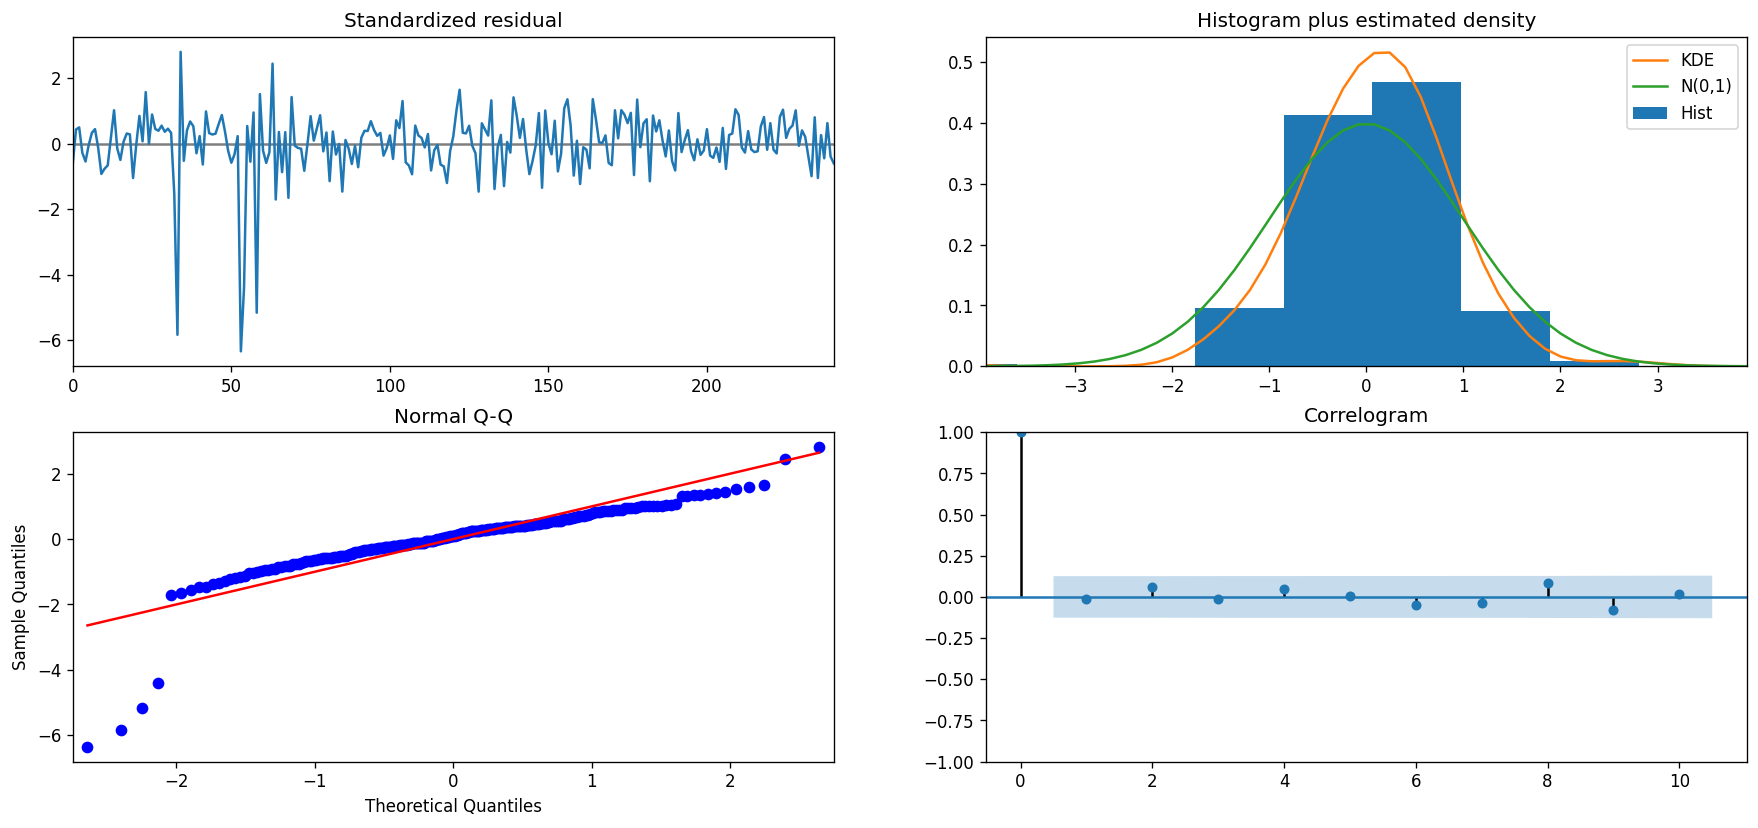

In [62]:
model.plot_diagnostics(figsize=(18,8))
plt.show()

Interpretation of plots in plot diagnostics
Standardized residual: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Histogram: The density plot suggest normal distribution with mean slighlty shifted towards right.

Theoretical Quantiles: Mostly the dots fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Correlogram: The Correlogram, (or ACF plot) shows the residual errors are not autocorrelated. The ACF plot would imply that there is some pattern in the residual errors which are not explained in the model. So we will need to look for more X’s (predictors) to the model.



## Evaluating the model performance with Forecast

Evaluation metrics


1.   the higher the R-squared, the better the model fits your data
2.   Lower values of RMSE indicate better fit. 



In [70]:
from sklearn.metrics import r2_score

# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-actual)[1]                      # ACF1
    r_2 = corr**2
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, #'acf1':acf1, 
            'corr':corr, 'minmax':minmax,'Rsquare':r_2})

## Train test Split (70 rows in test data)

In [97]:
from datetime import datetime
# df_train = df[(df['SurgDate'] <= '2012-07-31')]
# df_test = df[(df['SurgDate'] > '2012-07-31')]

# Create Training and Test
df_train = df['Actual'][:170]
df_test = df['Actual'][170:240]

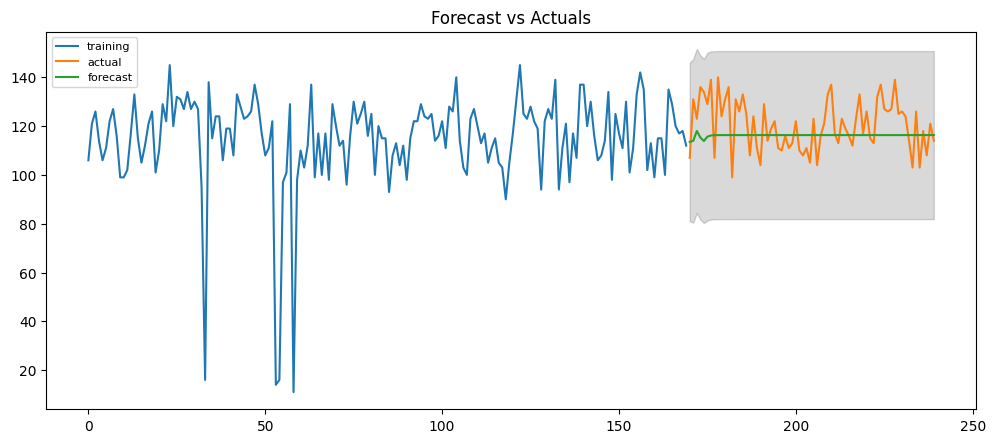

{'Rsquare': 0.009343795973948242,
 'corr': -0.09666331245073408,
 'mae': 9.307288197724775,
 'mape': 0.07555611219709794,
 'me': -4.213142418824066,
 'minmax': 0.07357457953337965,
 'mpe': -0.02776072210002652,
 'rmse': 11.214374843005045}

In [71]:
# Forecast
n_periods = 70
fc, conf = model.predict(n_periods=n_periods, return_conf_int=True)

# Make as pandas series
fc_series = pd.Series(fc, index=df_test.index)
lower_series = pd.Series(conf[:, 0], index=df_test.index)
upper_series = pd.Series(conf[:, 1], index=df_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label='training')
plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Accuracy metrics
forecast_accuracy(fc, df_test)

# ARMA Model with exogenous varaibles with T-7 to T-10

In [78]:


# SARIMAX Model without any seaonality
sxmodel = pm.auto_arima(df_train, exogenous=df[['T - 7', 'T - 8', 'T - 9', 'T - 10']][:170],
                      start_p=1, start_q=1,      
                      max_p=3, max_q=3, # maximum p and q
                      m=52,             # frequency of series
                      d=None, D=1,         
                      seasonal = True,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(sxmodel.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=903.871, Time=2.88 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=875.843, Time=36.10 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=902.041, Time=3.21 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=901.429, Time=3.80 sec
 ARIMA(1,0,0)(2,1,0)[52] intercept   : AIC=inf, Time=207.54 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(2,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=876.765, Time=35.82 sec
 ARIMA(2,0,0)(1,1,0)[52] intercept   : AIC=877.604, Time=49.97 sec
 ARIMA(1,0,1)(1,1,0)[52] intercept   : AIC=877.420, Time=68.98 sec
 ARIMA(0,0,1)(1,1,0)[52] intercept   : AIC=875.649, Time=47.21 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=900.257, Tim

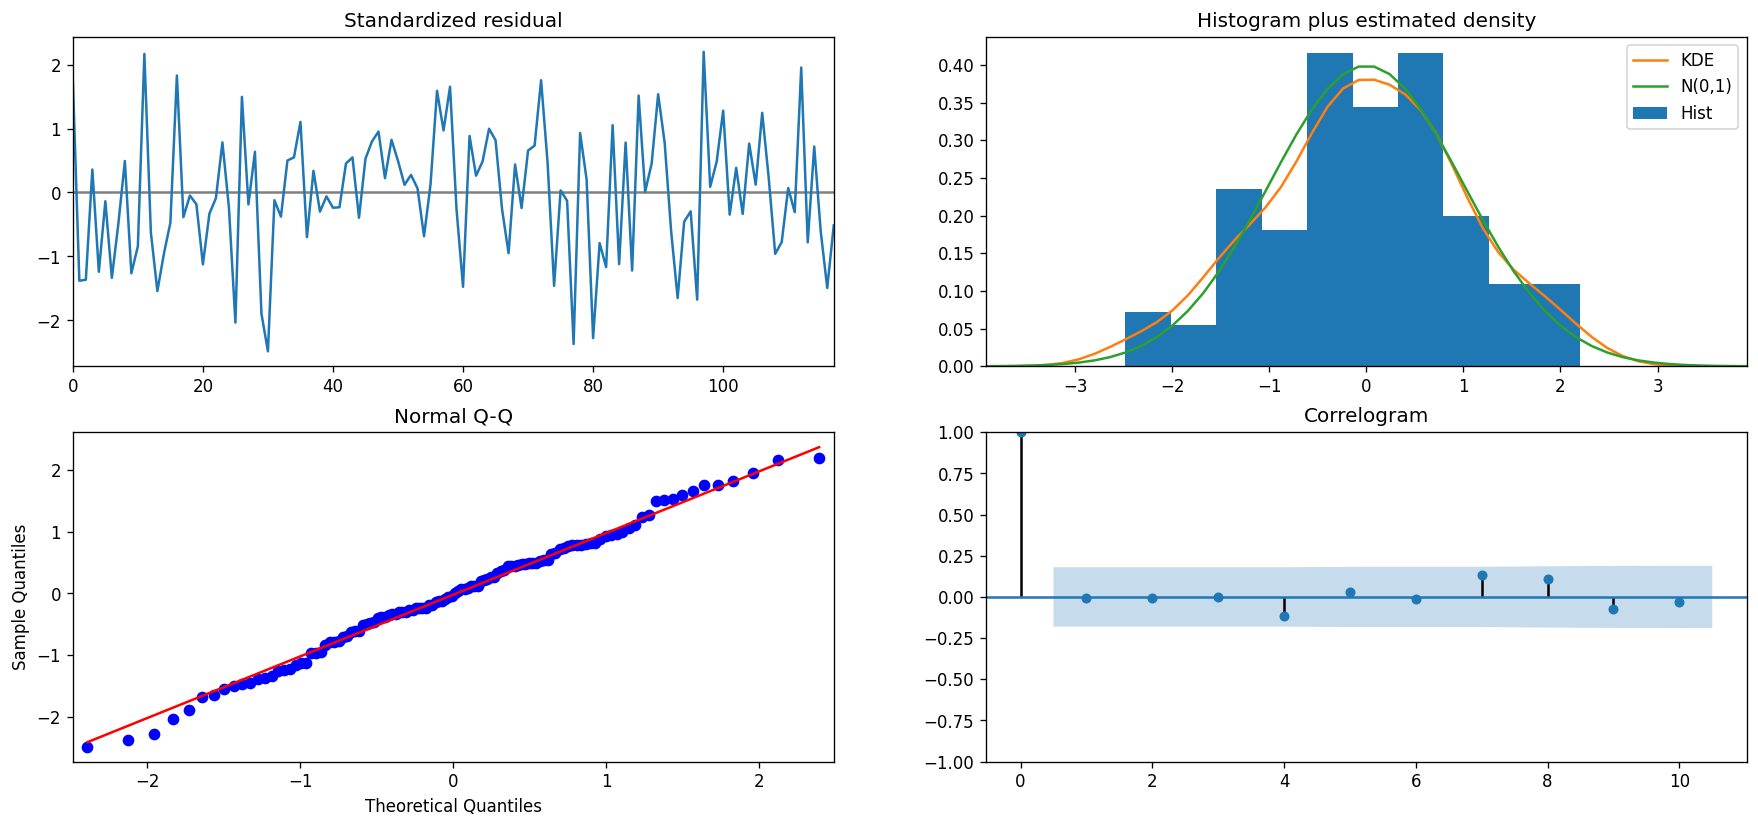

In [79]:
sxmodel.plot_diagnostics(figsize=(18,8))
plt.show()

## Evaluating Model Performane with Forecast (Exogenous Variables)

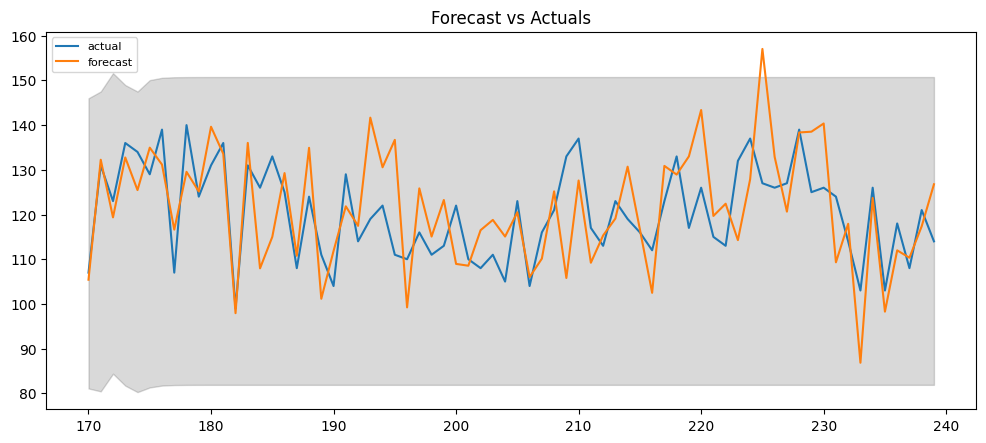

{'Rsquare': 0.35801662433732917,
 'corr': 0.5983449041625818,
 'mae': 8.531139895756905,
 'mape': 0.07073413873549188,
 'me': 0.8550951691836713,
 'minmax': 0.06670368645230451,
 'mpe': 0.00885070879262721,
 'rmse': 10.67427308991509}

In [81]:
# Forecast
n_periods = 70
fc, confint = sxmodel.predict(n_periods=n_periods, exogenous=df[['T - 7', 'T - 8', 'T - 9', 'T - 10']][170:240], return_conf_int=True)

# Make as pandas series
fc_series = pd.Series(fc, index=df_test.index)
lower_series = pd.Series(conf[:, 0], index=df_test.index)
upper_series = pd.Series(conf[:, 1], index=df_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)

plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Accuracy metrics
forecast_accuracy(fc, df_test)

# With T-1 to T-3 (3 days in advance)

In [82]:


# SARIMAX Model without any seaonality
sx1model = pm.auto_arima(df_train, exogenous=df[['T - 1', 'T - 2', 'T - 3']][:170],
                      start_p=1, start_q=1,      
                      max_p=3, max_q=3, # maximum p and q
                      m=52,             # frequency of series
                      d=None, D=1,         
                      seasonal = True,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(sx1model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=782.859, Time=1.46 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=inf, Time=38.95 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=782.920, Time=3.05 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=inf, Time=30.95 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=784.830, Time=4.73 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=784.819, Time=14.09 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=785.269, Time=8.29 sec

Best model:  ARIMA(0,0,0)(0,1,0)[52] intercept
Total fit time: 101.564 seconds
                            Statespace Model Results                            
Dep. Variable:                        y   No. Observations:                  170
Model:        

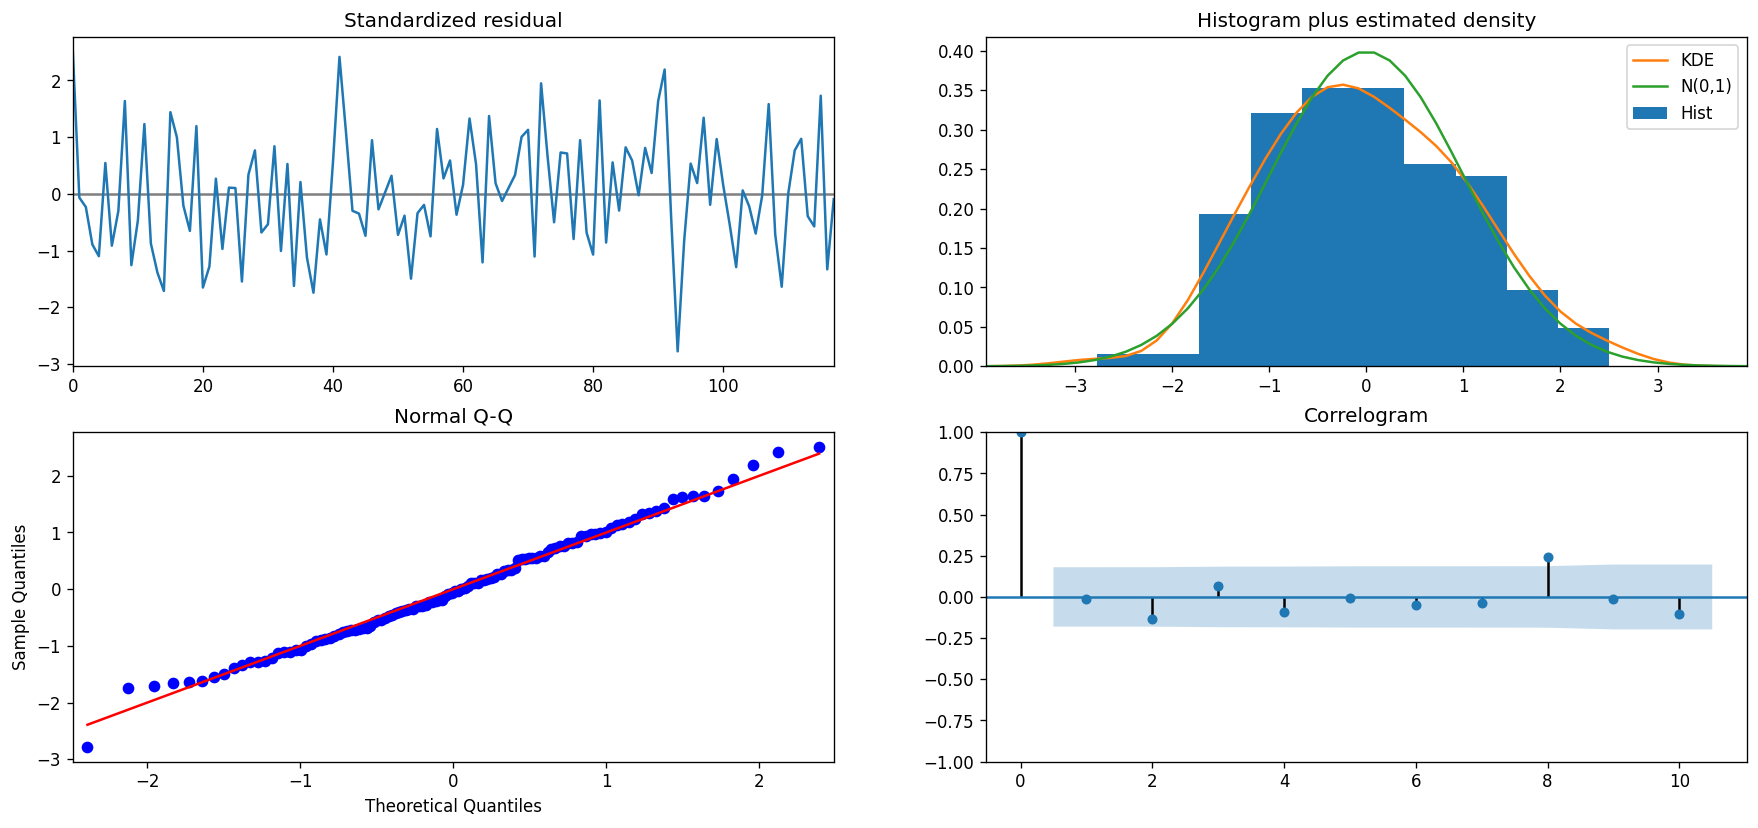

In [83]:
sx1model.plot_diagnostics(figsize=(18,8))
plt.show()

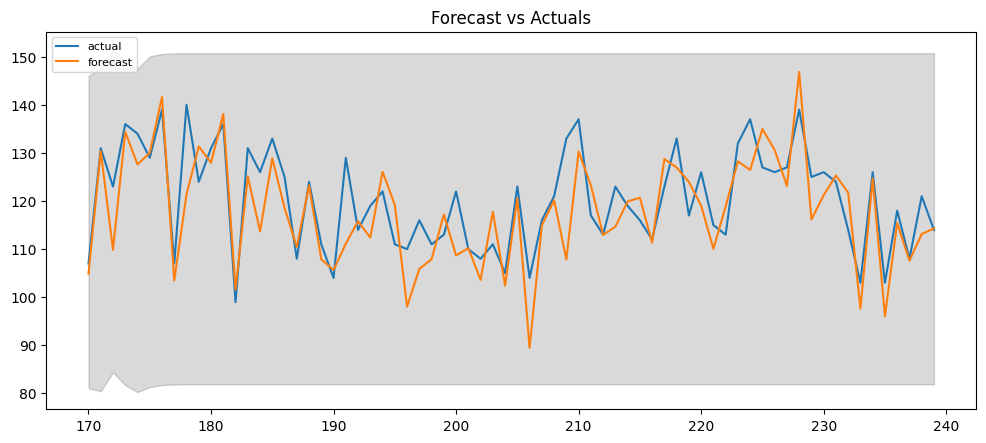

{'Rsquare': 0.6389932985726019,
 'corr': 0.7993705639893189,
 'mae': 5.583642104298563,
 'mape': 0.0459171521092969,
 'me': -2.5728552170804204,
 'minmax': 0.04532403900436022,
 'mpe': -0.02057455238370721,
 'rmse': 7.317215703852199}

In [85]:
# Forecast
n_periods = 70
fc, confint = sx1model.predict(n_periods=n_periods, exogenous=df[['T - 1', 'T - 2', 'T - 3']][170:240], return_conf_int=True)

# Make as pandas series
fc_series = pd.Series(fc, index=df_test.index)
lower_series = pd.Series(conf[:, 0], index=df_test.index)
upper_series = pd.Series(conf[:, 1], index=df_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)

plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Accuracy metrics
forecast_accuracy(fc, df_test)

# With T-1 to T-5 (5 days in advance)

In [88]:


# SARIMAX Model without any seaonality
sx2model = pm.auto_arima(df_train, exogenous=df[['T - 1', 'T - 2', 'T - 3','T - 4','T - 5']][:170],
                      start_p=1, start_q=1,      
                      max_p=3, max_q=3, # maximum p and q
                      m=52,             # frequency of series
                      d=None, D=1,         
                      seasonal = True,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(sx2model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=784.951, Time=4.27 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=inf, Time=55.24 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=785.021, Time=5.48 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=inf, Time=50.87 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=786.928, Time=5.08 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=786.920, Time=11.93 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=788.530, Time=17.61 sec

Best model:  ARIMA(0,0,0)(0,1,0)[52] intercept
Total fit time: 150.524 seconds
                            Statespace Model Results                            
Dep. Variable:                        y   No. Observations:                  170
Model:       

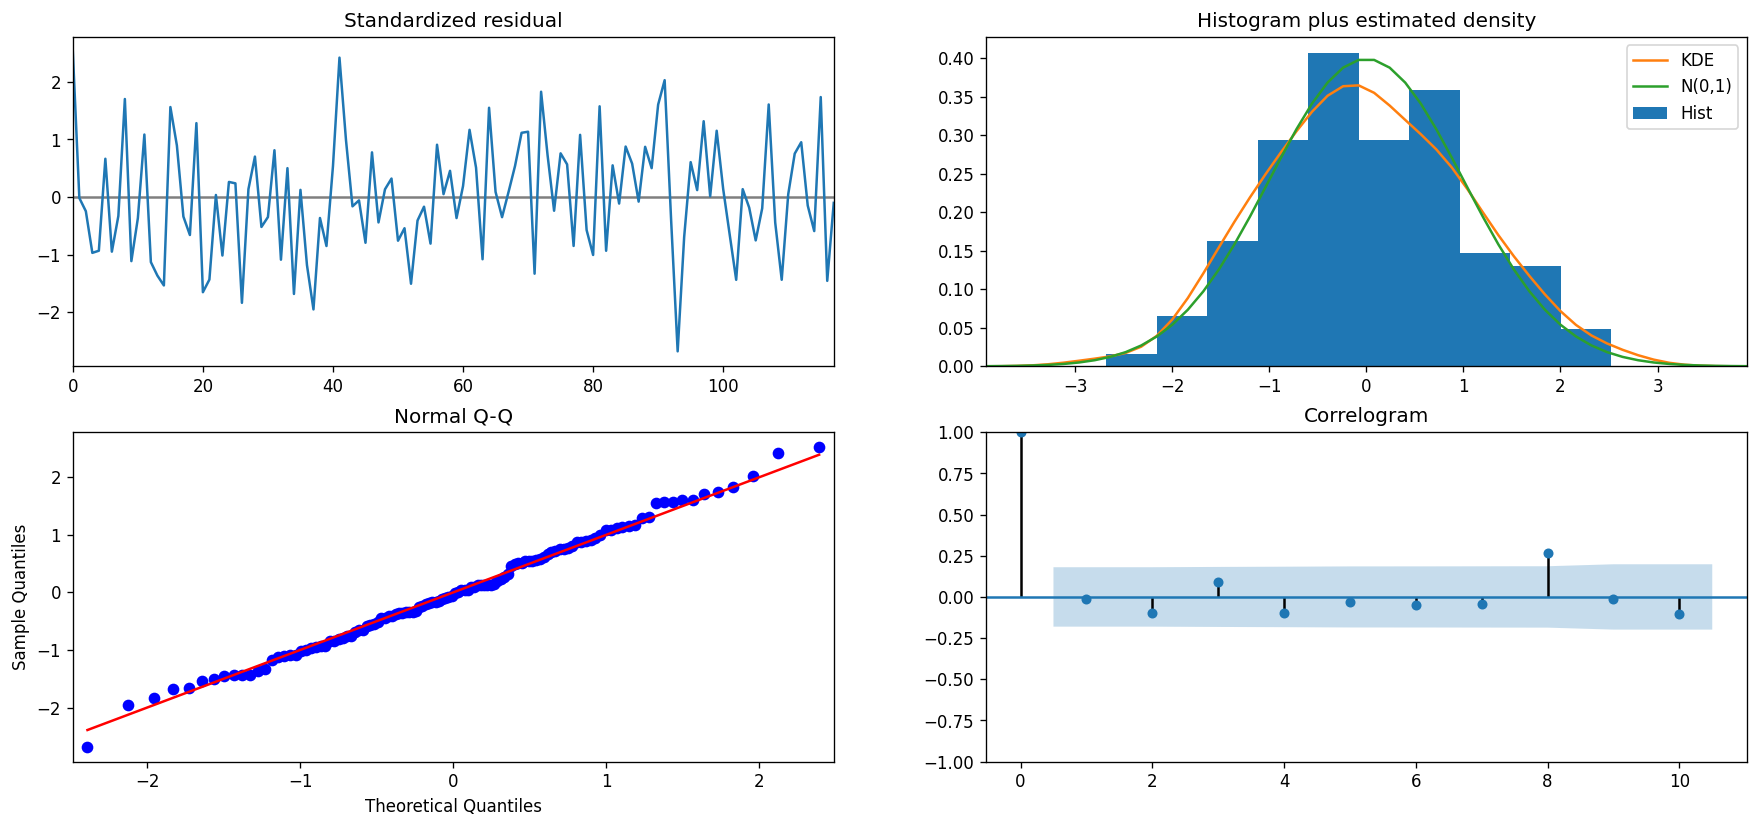

In [89]:
sx2model.plot_diagnostics(figsize=(18,8))
plt.show()

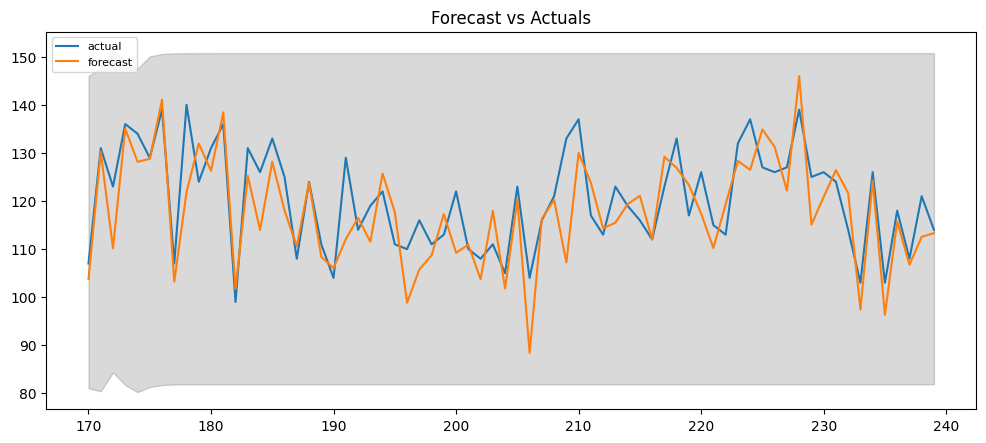

{'Rsquare': 0.6335211893804501,
 'corr': 0.7959404433627243,
 'mae': 5.689755166029972,
 'mape': 0.046842257431138457,
 'me': -2.6128750054455074,
 'minmax': 0.046248240602516755,
 'mpe': -0.020865306336950846,
 'rmse': 7.370465086713305}

In [91]:
# Forecast
n_periods = 70
fc, confint = sx2model.predict(n_periods=n_periods, exogenous=df[['T - 1', 'T - 2', 'T - 3','T - 4','T - 5']][170:240], return_conf_int=True)

# Make as pandas series
fc_series = pd.Series(fc, index=df_test.index)
lower_series = pd.Series(conf[:, 0], index=df_test.index)
upper_series = pd.Series(conf[:, 1], index=df_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)

plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Accuracy metrics
forecast_accuracy(fc, df_test)

# With T-1 to T-2 (2 days in advance)

In [92]:


# SARIMAX Model without any seaonality
sx3model = pm.auto_arima(df_train, exogenous=df[['T - 1', 'T - 2']][:170],
                      start_p=1, start_q=1,      
                      max_p=3, max_q=3, # maximum p and q
                      m=52,             # frequency of series
                      d=None, D=1,         
                      seasonal = True,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(sx3model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=785.781, Time=1.12 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=inf, Time=33.17 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=785.773, Time=1.99 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=inf, Time=17.23 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=787.747, Time=3.50 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=787.733, Time=11.49 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=788.564, Time=11.31 sec

Best model:  ARIMA(0,0,0)(0,1,0)[52]          
Total fit time: 79.860 seconds
                            Statespace Model Results                            
Dep. Variable:                        y   No. Observations:                  170
Model:        

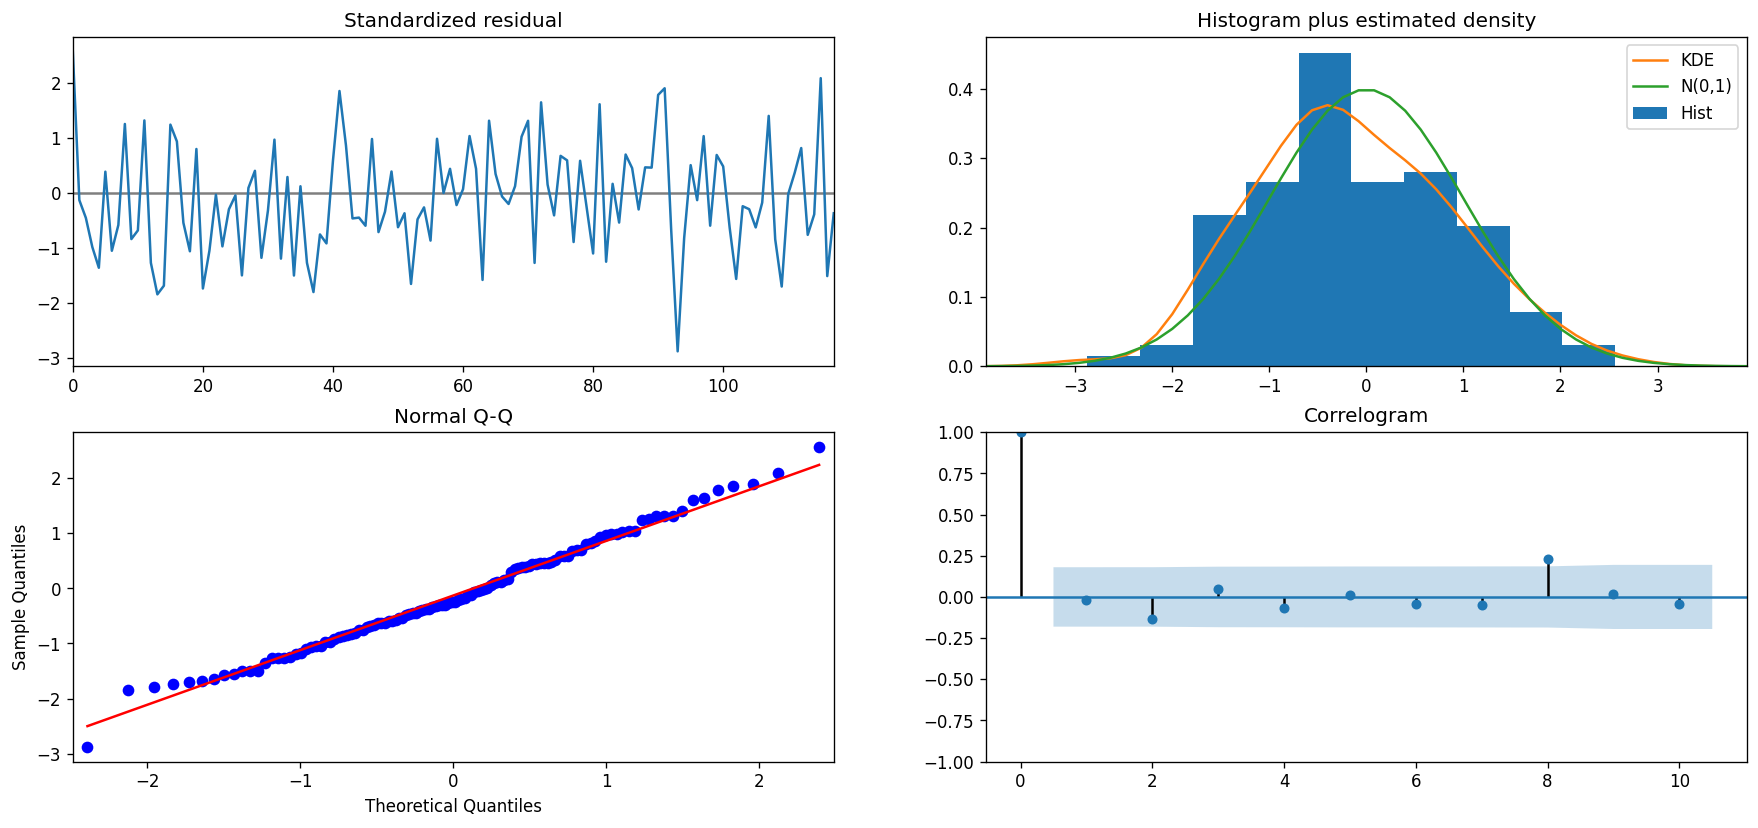

In [93]:
sx3model.plot_diagnostics(figsize=(18,8))
plt.show()

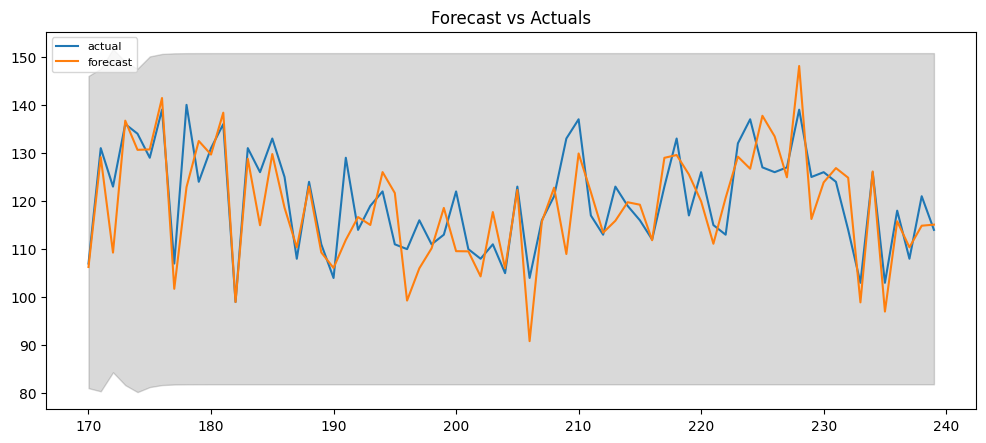

{'Rsquare': 0.6411082849628369,
 'corr': 0.8006923784842946,
 'mae': 5.241242615483643,
 'mape': 0.043108136386421796,
 'me': -1.566592343077942,
 'minmax': 0.04226048820446382,
 'mpe': -0.012277228777152399,
 'rmse': 7.078505538004415}

In [94]:
# Forecast
n_periods = 70
fc, confint = sx3model.predict(n_periods=n_periods, exogenous=df[['T - 1', 'T - 2']][170:240], return_conf_int=True)

# Make as pandas series
fc_series = pd.Series(fc, index=df_test.index)
lower_series = pd.Series(conf[:, 0], index=df_test.index)
upper_series = pd.Series(conf[:, 1], index=df_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)

plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Accuracy metrics
forecast_accuracy(fc, df_test)

# Taking only 30 rows in test and t-1 and t-2

In [96]:
# Create Training and Test
df_train1 = df['Actual'][:210]
df_test1 = df['Actual'][210:240]

In [99]:
# SARIMAX Model without any seaonality
sx31model = pm.auto_arima(df_train1, exogenous=df[['T - 1', 'T - 2']][:210],
                      start_p=1, start_q=1,      
                      max_p=3, max_q=3, # maximum p and q
                      m=52,             # frequency of series
                      d=None, D=1,         
                      seasonal = True,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(sx31model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[52]             : AIC=1028.443, Time=77.91 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1163.099, Time=6.49 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=20.59 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=31.83 sec
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=inf, Time=43.08 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=1026.462, Time=33.21 sec
 ARIMA(1,1,1)(0,1,0)[52]             : AIC=1062.807, Time=6.12 sec
 ARIMA(1,1,1)(2,1,0)[52]             : AIC=1028.447, Time=94.00 sec
 ARIMA(1,1,1)(2,1,1)[52]             : AIC=inf, Time=217.36 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1025.300, Time=22.30 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1061.977, Time=3.90 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=1027.294, Time=73.53 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1027.292, Time=41.84 sec
 ARIMA(0,1,1)(2,1,1)[52]             : AIC=inf, Time=179.28 sec
 ARIMA(0,1,0)(1,1,0)[52]       

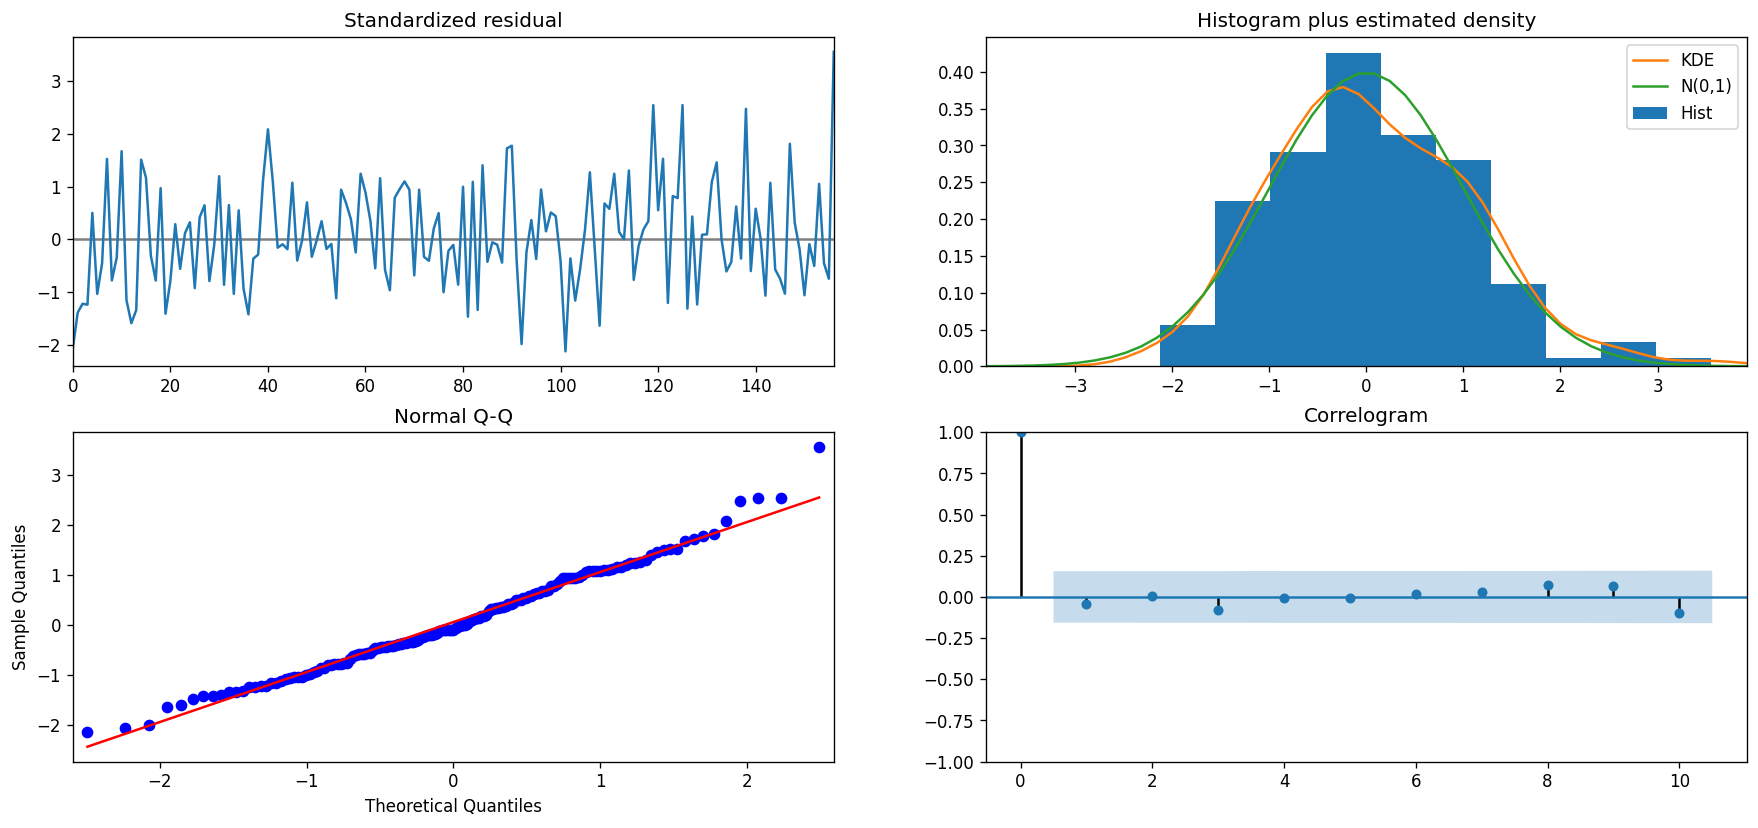

In [100]:
sx31model.plot_diagnostics(figsize=(18,8))
plt.show()

In [1]:
# Forecast
n_periods = 30
fc, confint = sx31model.predict(n_periods=n_periods, exogenous=df[['T - 1', 'T - 2']][210:240], return_conf_int=True)

# Make as pandas series
fc_series = pd.Series(fc, index=df_test1.index)
lower_series = pd.Series(conf[:, 0], index=df_test1.index)
upper_series = pd.Series(conf[:, 1], index=df_test1.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)

plt.plot(df_test1, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Accuracy metrics
forecast_accuracy(fc, df_test1)

NameError: ignored